# Comparing statistical significances of composites

In [1]:
from importlib import reload
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy as ctp

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")


In [3]:
# Load data
# =======================================================================================
reload(preproc)
vars = ['olr']
climatology = 'month'
f_sst = "../data/reanalysis/monthly/ERA5/sea_surface_temperature_era5_monthly_sp_1940-2022_1.0x1.0.nc"

datapath = {
    'sst':    f"../data/reanalysis/monthly/CERA-20C/sst_cera20c_1901-2009_r1x1.nc",
    'ssh':    f"../data/reanalysis/monthly/ORAS5/sea_surface_height_oras5_single_level_1958_2023_1x1.nc",
    't2m':    f"../data/reanalysis/monthly/ERA5/2m_temperature_era5_monthly_sp_1940-2022_2.5x2.5.nc",
    'olr':    f"../data/reanalysis/monthly/ERA5/olr_era5_monthly_sp_1940-2022_2.5x2.5.nc",
}

da4comp_arr = []
for var in vars:
    print(f"Load {var}")
    temp = preproc.process_data(
        datapath[var], vars=[var], antimeridian=False,
        lon_range=[-180, 179], lat_range=[-80, 80],
        grid_step=2.5, climatology=climatology, normalization=None
    )
    temp = temp[f"{var}a"]
    temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
    da4comp_arr.append(temp)
ds4comp = xr.merge(da4comp_arr)


Load olr
Sort longitudes and latitudes in ascending order, respectively
Process olr:
Get selected area: lon=[-180, 179], lat=[-80, 80]!
Interpolate grid on res 2.5
Detrend and compute anomalies:


/tmp/ipykernel_45086/1491719404.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_45086/1491719404.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convert

## Unweighted composites

In [4]:
# Parameters
n_samples_mean = 500
alpha = 0.05
null_hypothesis = 'neutral'
stattest = 'pos'
multiple_testing= None

In [68]:
from tqdm import tqdm
# Get enso types for conditioning 
enso_types=['Nino_CP']#, 'Nino_CP','Nina_EP', 'Nina_CP']
criteria='N3N4'
enso_months =[12, 2]
enso_classes = utenso.get_enso_flavors_obs(
    definition=criteria, fname=f_sst, vname='sst', climatology='month',
    month_range=enso_months,
)

# Null hypothesis
null_hypothesis = 'neutral'
if null_hypothesis == 'neutral':
    # Neutral years as null hypothesis
    time_snippets_null = np.array(
        [enso_classes.loc[enso_classes['type'] == 'Normal']['start'],
         enso_classes.loc[enso_classes['type'] == 'Normal']['end']]
    ).T
elif null_hypothesis == 'all':
    # All winters as null hypothesis
    time_snippets_null = np.array(
        [enso_classes['start'],
         enso_classes['end']]
    ).T
else:
    raise ValueError(f"Unknown null hypothesis: {null_hypothesis}")

composite_null = []
for var in ds4comp.data_vars:
    da = ds4comp[var]

    # Neutral DJF
    da_null = preproc.select_time_snippets(da, time_snippets_null)
    mean_null = da_null.mean(dim='time', skipna=True)

    for i, enso_type in enumerate(enso_types):
        # Composites
        time_snippets = np.array(
            [enso_classes.loc[enso_classes['type'] == enso_type]['start'],
             enso_classes.loc[enso_classes['type'] == enso_type]['end']]
        ).T
        da_flavor = preproc.select_time_snippets(da, time_snippets)
        print(f"Num of datapoints {enso_type}: {len(da_flavor['time'])}")

        # Mean
        mean_flavor = da_flavor.mean(dim='time', skipna=True)

        # Sample means
        n_samples_flavor = len(da_flavor['time'])
        n_samples_null = len(da_null['time'])
        samples_class = []
        for n in tqdm(range(n_samples_mean)):
            # Sample flavor
            time_samples = np.random.choice(da_flavor['time'], size=n_samples_flavor,
                                            replace=True)
            mean_sample_flavor = da_flavor.sel(time=time_samples).mean(dim='time')

            # Sample null
            time_samples = np.random.choice(da_null['time'], size=n_samples_null,
                                            replace=True)
            mean_sample_null = da_null.sel(time=time_samples).mean(dim='time')

            # Difference
            samples_class.append(mean_sample_flavor - mean_sample_null)

        samples_class = xr.concat(samples_class, dim='samples')


Sort longitudes and latitudes in ascending order, respectively
Num of datapoints Nino_CP: 24


100%|██████████| 500/500 [00:02<00:00, 220.32it/s]


In [69]:
p_values_flavor = (np.abs(samples_class) >= np.abs(mean_flavor - mean_null)).mean(dim='samples') 
mask_flavor = utstats.field_significance_mask(p_values_flavor, alpha=0.50, corr_type=multiple_testing)

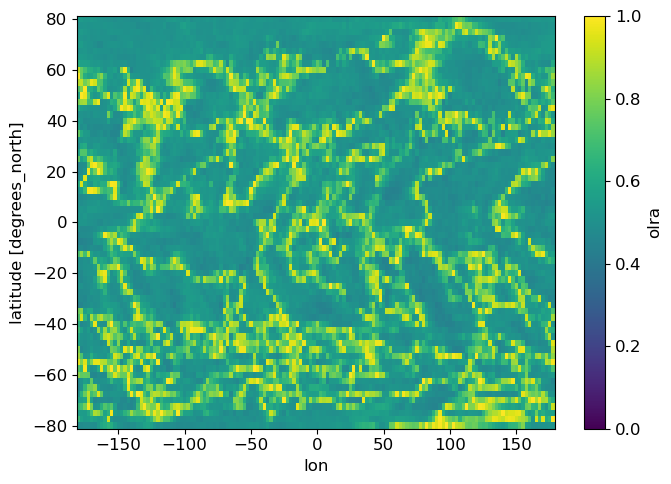

In [70]:
p_values_flavor.plot(vmin=0, vmax=1.0)

{'ax': <GeoAxes: >,
 'im': <matplotlib.collections.PolyCollection at 0x7f6acfedfa90>}

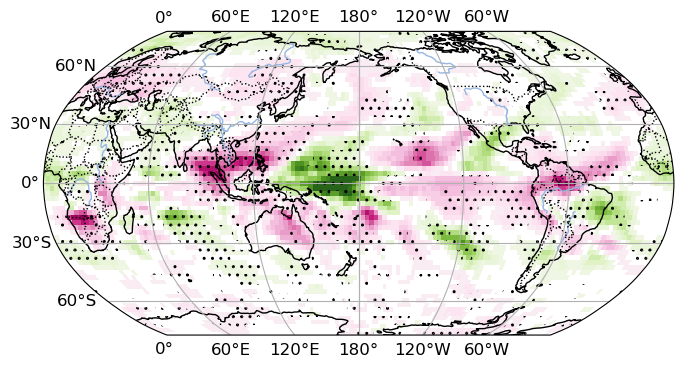

In [72]:
plotspec = {
    'ssta': dict(cmap='RdBu_r', vmin=-1.5, vmax=1.5, step=.25, label='SST anomaly [K]'),
    'ssha': dict(cmap='RdGy_r', vmin=-.15, vmax=.15, step=.025, label='SSH anomaly [m]'),
    't2ma': dict(cmap='RdBu_r', vmin=None, vmax=None, step=.25, label='2m temperature anomaly'),
    'olra': dict(cmap='PiYG_r', vmin=-15, vmax=15, step=1, label=r'OLR anomaly [W/$m^2$]'),
}
var='olra'

fig = plt.figure()
central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)
ax = fig.add_subplot(1,1,1, projection=proj)
im = gpl.plot_map(mean_sample_flavor, central_longitude=0, ax=ax,
                  bar='discrete', add_bar=False,
                  cmap=plotspec[var]['cmap'],
                  vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                  step=plotspec[var]['step'], centercolor='#FFFFFF')
gpl.significance_mask(mask_flavor, ax=ax,
                      central_longitude=0)

In [ ]:
# Unweighted composites
reload(utenso)
composites_unweight, mask_unweight, composites_null, samples_null_unweight, pvalues_unweight = utenso.get_unweighted_composites(
    ds4comp, f_sst, stattest=stattest, null_hypothesis=null_hypothesis,
    n_samples_mean=n_samples_mean, n_samples_time=n_samples_time, alpha=alpha,
    serial_data=False, multiple_testing=multiple_testing
)


In [ ]:
# Plot unweighted composites
n_columns = len(composites_unweight.data_vars)
n_rows = len(composites_unweight['classes']) + 1
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows+1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)

axs = []
for j in range(n_columns):
    var = list(composites_unweight.data_vars)[j]

    # Neutral composites
    ax = fig.add_subplot(gs[0, j], projection=proj)
    im = gpl.plot_map(composites_null[var], central_longitude=0, ax=ax,
                      bar='discrete', add_bar=False,
                      cmap=plotspec[var]['cmap'],
                      vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                      step=plotspec[var]['step'], centercolor='#FFFFFF')
#    ax.set_title(f"Neutral")
    axs.append(ax)
    im['gl'].top_labels = False
    im['gl'].right_labels = False
    im['gl'].bottom_labels = False

    # ENSO flavor composites
    for i in range(len(composites_unweight['classes'])):
        comp = composites_unweight[var].isel(classes=i)
        mask = mask_unweight[var].isel(classes=i)
        ax = fig.add_subplot(gs[i+1, j], projection=proj)

        im = gpl.plot_map(comp, central_longitude=0, ax=ax,
                          bar='discrete', add_bar=False,
                          cmap=plotspec[var]['cmap'],
                          vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                          step=plotspec[var]['step'], centercolor='#FFFFFF')
        gpl.significance_mask(mask, ax=ax,
                              central_longitude=0)
        # Remove labels
        im['gl'].top_labels = False
        im['gl'].right_labels = False
        if i+1 == n_rows-1:
            im['gl'].bottom_labels = True
        else:
            im['gl'].bottom_labels = False

        # Set number of significant points as title
        n_nan = np.count_nonzero(np.isnan(mask.data.flatten()))
        ratio_significant = np.count_nonzero(mask.data.flatten()) / (len(mask.data.flatten()) - n_nan) * 100
        ax.set_title(f"{ratio_significant:.1f}%")
        axs.append(ax)

    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{plotspec[var]['label']}", size=16)

_ = gpl.enumerate_subplots(np.array(axs).T, pos_x=-0.07, pos_y=1.06, fontsize=16)


## Probabilistic weighted composites

In [ ]:
# Load weights
weight_month_mean = xr.open_dataset(
    "../output/pcgmm/pcgmm_weights_month_sst.nc"
    "../output/pcgmm/pcgmm_weights_month_sst.nc"
)['p_c_given_x']
gmm_order = weight_month_mean.attrs['gmm_sort']


In [ ]:
# Weighted composites
composites_prob, mask_prob, samples_null_prob, pvals_prob = utenso.get_weighted_composites(
    ds4comp, f_sst, weight_month_mean, null_hypothesis=null_hypothesis,
    stattest=stattest, n_samples_mean=n_samples_mean, n_samples_time=n_samples_time, alpha=alpha,
    multiple_testing=multiple_testing, serial_data=False
)


In [ ]:
# Plot weighted composites
# ===============================================
plotspec = {
    'ssta': dict(cmap='RdBu_r', vmin=-1.5, vmax=1.5, step=.25, label='SST anomaly [K]'),
    'ssha': dict(cmap='RdGy_r', vmin=-.15, vmax=.15, step=.025, label='SSH anomaly [m]'),
    't2ma': dict(cmap='RdBu_r', vmin=None, vmax=None, step=.25, label='2m temperature anomaly'),
    'olra': dict(cmap='PiYG_r', vmin=-20, vmax=20, step=2.5, label=r'OLR anomaly [W/$m^2$]'),
}
n_columns = len(composites_prob.data_vars)
n_rows = len(composites_prob['classes'])
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows + 1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)

axs = []
for j in range(n_columns):
    for i in range(n_rows):
        idx = gmm_order[i] + 1
        var = list(composites_prob.data_vars)[j]
        comp = composites_prob[var].sel(classes=idx)
        mask = mask_prob[var].sel(classes=idx)
        ax = fig.add_subplot(gs[i, j], projection=proj)

        im = gpl.plot_map(comp, central_longitude=0, ax=ax,
                          bar='discrete', add_bar=False,
                          cmap=plotspec[var]['cmap'],
                          vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                          step=plotspec[var]['step'], centercolor='#FFFFFF')
        gpl.significance_mask(mask, ax=ax, hatch="..",
                              central_longitude=0)
        # Remove labels
        im['gl'].top_labels = False
        im['gl'].right_labels = False
        if i == n_rows-1:
            im['gl'].bottom_labels = True
        else:
            im['gl'].bottom_labels = False
        # Set number of significant points as title
        n_nan = np.count_nonzero(np.isnan(mask.data.flatten()))
        ratio_significant = np.count_nonzero(mask.data.flatten()) / (len(mask.data.flatten()) - n_nan) * 100
        ax.set_title(f"{ratio_significant:.1f}%")
        axs.append(ax)

    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{plotspec[var]['label']}", size=16)

_ = gpl.enumerate_subplots(np.array(axs).T, pos_x=-
                           0.07, pos_y=1.06, fontsize=16)

## Plot histograms

In [ ]:
idx = 3
var = 'olra'
lat = 0.0
lon = 178 
mean = composites_unweight[var].isel(classes=idx)
mask = mask_unweight[var].isel(classes=idx)
samples_null = samples_null_unweight[var]

fig = plt.figure(figsize=(6,7))

central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)
ax1 = fig.add_subplot(211, projection=proj)
im = gpl.plot_map(mean,
                  ax=ax1, central_longitude=0, 
                  bar='discrete', add_bar=False,
                  cmap=plotspec[var]['cmap'],
                  vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                  step=plotspec[var]['step'], centercolor='#FFFFFF')
gpl.significance_mask(mask, ax=ax1, hatch='..',
                      central_longitude=0)

ax1.scatter(lon, lat, transform=ctp.crs.PlateCarree(),
           marker='*', color='b', s=200)
ax1.set_title(f"{mean['classes'].data}")
# Hist
ax2 = fig.add_subplot(212)
ax2.axvline(mean.sel(lon=lon, lat=lat, method='nearest'), color='k', label='mean')
ax2.hist(samples_null.sel(lon=lon, lat=lat, method='nearest').data,
        bins='auto', density=True, alpha=0.5, label='null')
ax2.legend()
ax2.set_title(f"PoS: {pvals_prob[var].isel(classes=idx).sel(lon=lon, lat=lat, method='nearest').data:.2f}"+
      f", significance: {mask.sel(lon=lon, lat=lat, method='nearest').data}")
